# A Toy Classifier For Fashion-MNIST Dataset

## 1. Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## 2. Prepare dataset

In [45]:
fashion_mnist = keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

## 3. Explore the dataset

In [46]:
print(training_images.shape)
print(training_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


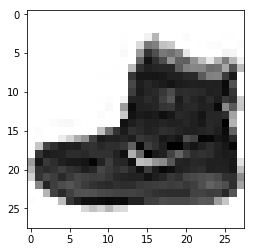

In [47]:
plt.figure()
plt.imshow(training_images[0], cmap = plt.cm.binary)
plt.show()

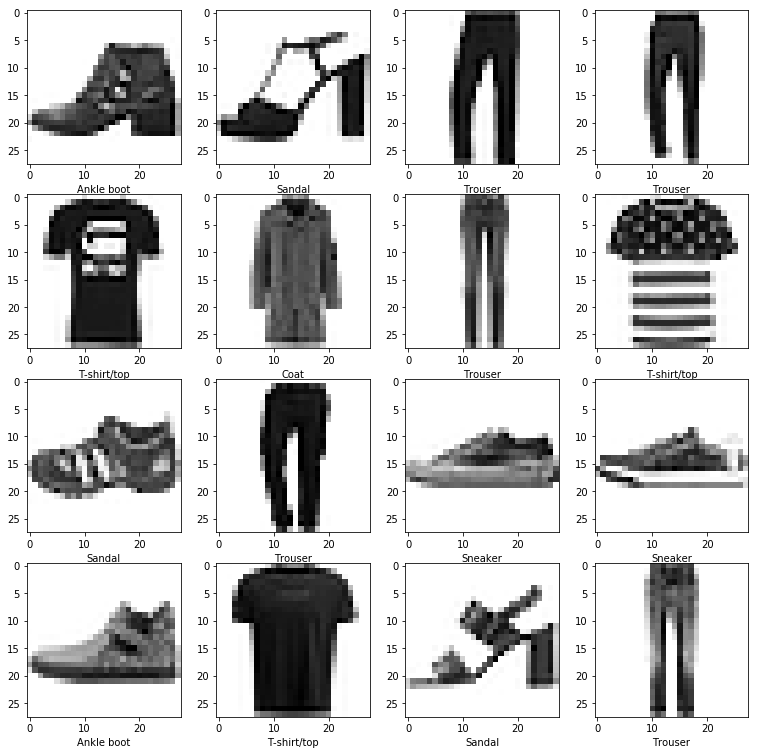

In [52]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(13,13))
col_length, row_length = 4,4
sampling_num = col_length*row_length
random_indices = np.random.randint(0, training_images.shape[0], size=sampling_num)
#random_indices = list(range(sampling_num))
for i in range(sampling_num):
    plt.subplot(col_length,row_length,i+1)
    plt.grid(False)
    plt.imshow(training_images[random_indices[i]][:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[training_labels[random_indices[i]]])
plt.show()

After examination of the dataset, we find:
1. the dimension for each image is (28, 28), which does not fit in tf conv layers.
2. there are mistakes in training set labels.
3. some of these items are easy to classify, but some are harder, we can try hierachy classifier.

## 4. Preprocessing

In [49]:
# change dim so agree with tf.Conv2D
training_images = np.reshape(training_images, (training_images.shape[0], training_images.shape[1], training_images.shape[2], 1))
test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2], 1))
print(training_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [50]:
# norm to 0-1 for better perfermance
training_images = training_images / 255.0
test_images = test_images / 255.0

In [51]:
# split test set for test and validation
validation_num = 2000
validation_images, test_images = test_images[:validation_num, :, :, :], test_images[validation_num:, :, :, :]
validation_labels, test_labels = test_labels[:validation_num], test_labels[validation_num:]
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2000, 28, 28, 1)
(2000,)
(8000, 28, 28, 1)
(8000,)


## 5. Design the model

First try, easy and shallow conv-net

In [71]:
input_node = keras.Input(shape=(28, 28, 1))
node = keras.layers.Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding='valid')(input_node)
node = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid')(node)
node = keras.layers.MaxPool2D()(node)
node = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid')(node)
node = keras.layers.MaxPool2D()(node)
node = keras.layers.Flatten()(node)
node = keras.layers.Dropout(0.4)(node)
node = keras.layers.Dense(units=256, activation='tanh')(node)
node = keras.layers.Dense(units=128, activation='tanh')(node)
node = keras.layers.Dropout(0.5)(node)
output_node = keras.layers.Dense(units=10, activation='softmax')(node)
model = keras.Model(inputs=[input_node], outputs=[output_node])

## 6. Train the model

In [72]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [73]:
model.fit(training_images, training_labels, batch_size=256, epochs=10, validation_data=(validation_images, validation_labels))

Train on 60000 samples, validate on 2000 samples
Epoch 1/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 0.6190 - accuracy: 0.7789 - val_loss: 0.4054 - val_accuracy: 0.8605
Epoch 2/10
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.4131 - accuracy: 0.8541 - val_loss: 0.3312 - val_accuracy: 0.8775
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.3598 - accuracy: 0.8719 - val_loss: 0.2897 - val_accuracy: 0.9005
Epoch 4/10
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.3321 - accuracy: 0.8814 - val_loss: 0.2880 - val_accuracy: 0.8970
Epoch 5/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.3057 - accuracy: 0.8901 - val_loss: 0.2644 - val_accuracy: 0.9080
Epoch 6/10
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.2830 - accuracy: 0.8992 - val_loss: 0.2661 - val_accuracy: 0.9055
Epoch 7/10
60000/60000 [============================

## 7. Evaluation the model

Check overall performance by accuracy or other metrics

In [74]:
loss_and_metrics = model.evaluate(test_images, test_labels)
print(loss_and_metrics)

8000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.26756528839468957, 0.905]


Check negative samples to gain some intuition

In [75]:
Y_hat = model.predict(test_images)
predicted_labels = np.argmax(Y_hat, axis=1)
indices = predicted_labels != test_labels
unmatch_images = test_images[indices]
unmatch_predicted_labels = predicted_labels[indices]
unmatch_test_labels = test_labels[indices]

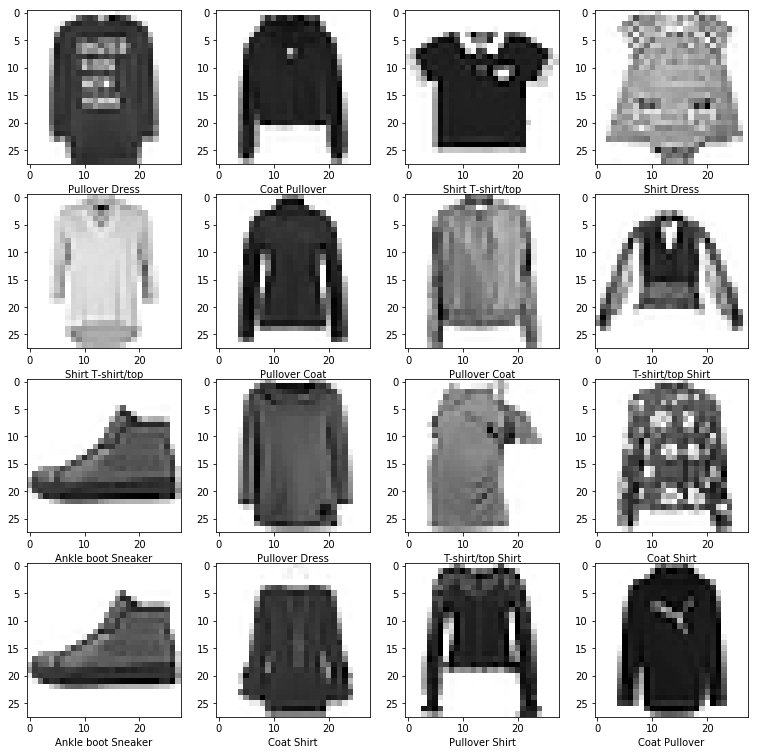

In [76]:
plt.figure(figsize=(13,13))
col_length, row_length = 4,4
sampling_num = col_length*row_length
random_indices = np.random.randint(0, unmatch_images.shape[0], size=sampling_num)
#random_indices = list(range(sampling_num))
for i in range(sampling_num):
    plt.subplot(col_length,row_length,i+1)
    plt.grid(False)
    plt.imshow(unmatch_images[random_indices[i]][:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[unmatch_predicted_labels[random_indices[i]]] +" "+class_names[unmatch_test_labels[random_indices[i]]])
plt.show()